# Tree shape diversity

### The plot elements below will be saved to `/analysis/output/NDS-LB/`

In [110]:
import glob
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm, SymLogNorm

## Load GC trees and constuct a data frame of statistics

In [111]:
results = "../nextflow/results"

In [112]:
metadata_PR1 = pd.read_csv("../metadata.PR1.csv")[["imm_duration", "strain", "mouse", "gc", "node", "cell_type"]]
metadata_PR1["pr"] = "1"
metadata_PR1["gc"] = metadata_PR1["gc"].astype(str)
metadata_PR1.rename({"imm_duration": "time"}, axis=1, inplace=True)
metadata_PR2 = pd.read_csv("../metadata.PR2.csv")[["mouse", "gc", "node", "cell_type"]]
metadata_PR2["pr"] = "2"
metadata_PR2["time"] = "d15"
metadata_PR2["strain"] = "wt"

metadata = pd.concat([metadata_PR1, metadata_PR2], ignore_index=True)
metadata.index = "PR" + metadata["pr"] + "_mouse" + metadata["mouse"].astype(str) + "_GC" + metadata["gc"]
metadata

,time,strain,mouse,gc,node,cell_type,pr
PR1_mouse1_GC1,d20,wt,1,1,RP,GC,1
PR1_mouse1_GC2,d20,wt,1,2,RP,GC,1
PR1_mouse1_GC3,d20,wt,1,3,RP,GC,1
PR1_mouse1_GC4,d20,wt,1,4,LP,GC,1
PR1_mouse1_GC5,d20,wt,1,5,LP,GC,1
...,...,...,...,...,...,...,...
PR2_mouse12_GC12B,d15,wt,12,12B,LP,GC,2
PR2_mouse12_GC12D,d15,wt,12,12D,LI,GC,2
PR2_mouse12_GC12C,d15,wt,12,12C,RI,GC,2
PR2_mouse10_GC10A,d15,wt,10,10A,RP,GC,2


In [113]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[0].split(".")[0][2:]), int(PR_str[1]), PR_str[3]

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("PR", "mouse", "GC"), gc_key(file)))
    if (metadata.strain[key] == "wt") and (metadata.time[key] in ("d15", "d20")):
        print(key)
        assert key not in trees, key
        trees[key] = pickle.load(open(file, "rb"))

    
#     trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
#          for file in files}

print(f"loaded {len(trees)} GC trees")

PR1_mouse1_GC1
PR1_mouse1_GC11
PR1_mouse1_GC12
PR1_mouse1_GC13
PR1_mouse1_GC14
PR1_mouse1_GC15
PR1_mouse1_GC16
PR1_mouse1_GC17
PR1_mouse1_GC18
PR1_mouse1_GC19
PR1_mouse1_GC2
PR1_mouse1_GC20
PR1_mouse1_GC3
PR1_mouse1_GC4
PR1_mouse1_GC5
PR1_mouse1_GC6
PR1_mouse1_GC7
PR1_mouse2_GC21
PR1_mouse2_GC22
PR1_mouse2_GC23
PR1_mouse2_GC24
PR1_mouse2_GC25
PR1_mouse2_GC26
PR1_mouse2_GC28
PR1_mouse2_GC29
PR1_mouse2_GC30
PR1_mouse2_GC31
PR1_mouse2_GC32
PR1_mouse2_GC34
PR1_mouse2_GC38
PR1_mouse2_GC39
PR1_mouse2_GC40
PR1_mouse3_GC41
PR1_mouse3_GC42
PR1_mouse3_GC43
PR1_mouse3_GC44
PR1_mouse3_GC45
PR1_mouse3_GC46
PR1_mouse3_GC55
PR1_mouse3_GC56
PR1_mouse3_GC57
PR1_mouse3_GC58
PR1_mouse3_GC59
PR1_mouse3_GC64
PR1_mouse3_GC65
PR1_mouse3_GC66
PR1_mouse3_GC72
PR1_mouse4_GC47
PR1_mouse4_GC48
PR1_mouse4_GC50
PR1_mouse4_GC63
PR1_mouse4_GC67
PR1_mouse4_GC68
PR1_mouse4_GC69
PR1_mouse4_GC70
PR1_mouse4_GC71
PR1_mouse4_GC73
PR1_mouse5_GC78
PR1_mouse5_GC79
PR1_mouse5_GC80
PR1_mouse5_GC81
PR1_mouse5_GC82
PR1_mouse5_GC83

In [114]:
stat = "REI"
# taus = np.logspace(-2, 0, 10)
taus = np.linspace(0.05, 1, 20)
# taus = [0.05, 0.1, 1]

# stat = "LBI"
# taus = np.logspace(-1, 1, 50)

In [115]:
def calc_tree_stat(tree, stat, tau):
    if stat == "REI":
        total_abundance = sum(node.abundance for node in tree.tree.traverse())
        for node in tree.tree.traverse():
            node.REI = sum(node2.abundance * tau ** node2.get_distance(node) for node2 in node.traverse()) / total_abundance
    elif stat.startswith("LB"):
        tree.local_branching(tau=tau)
    else:
        raise ValueError(f"unknown stat {stat}")

In [116]:
df = pd.DataFrame()

row = 0
for tau in taus:
    for key, tree in trees.items():
        pr, mouse, gc = key.split("_")
        mouse = mouse.lstrip("mouse")

        calc_tree_stat(tree, stat, tau)
        
        gc = gc.lstrip("GC")
        df.loc[row, "τ"] = tau
        df.loc[row, "PR"] = pr
        df.loc[row, "mouse"] = pr + "_" + mouse
        df.loc[row, "germinal center"] = pr + "_mouse" + mouse + "_GC" + gc
        df.loc[row, "time"] = metadata.time[key]
        
        abundances = np.array([node.abundance for node in tree.tree.traverse()])

        if len(tree.tree.children) == 1:
            root = tree.tree.children[0]
        else:
            root = tree.tree
        clade_sizes = [sum(node.abundance for node in child.traverse()) for child in root.children]
        df.loc[row, "cells sampled"] = sum(abundances)
        df.loc[row, "normalized dominance score"] = max(clade_sizes) / sum(clade_sizes)
        df.loc[row, f"maximum {stat}"] = np.nanmax([getattr(node, stat) for node in tree.tree.traverse()])    
        
        # note: additive delta_bind for now
        delta_bind_dat = []
        for node in tree.tree.traverse():
            if not np.isnan(node.delta_bind):
                for _ in range(node.abundance):
                    delta_bind_dat.append(node.delta_bind)
        df.loc[row, "max Δaffinity"] = np.nanmax(delta_bind_dat)
        df.loc[row, "95th percentile Δaffinity"] = np.percentile(delta_bind_dat, 95)
        df.loc[row, "mean Δaffinity"] = np.nanmean(delta_bind_dat)
        df.loc[row, "median Δaffinity"] = np.nanmedian(delta_bind_dat)

        max_stat_idx = np.nanargmax([getattr(node, stat) for node in tree.tree.traverse()])
        df.loc[row, f"Δaffinity of max {stat} node"] = [node.delta_bind for node in tree.tree.traverse()][max_stat_idx]
        df.loc[row, f"ΔΔaffinity of max {stat} node"] = [node.delta_bind - (node.up.delta_bind if node.up is not None else 0) for node in tree.tree.traverse()][max_stat_idx]
        df.loc[row, f"max {stat} node is root"] = max_stat_idx == 0

        row += 1

df

,τ,PR,mouse,germinal center,time,cells sampled,normalized dominance score,maximum REI,max Δaffinity,95th percentile Δaffinity,mean Δaffinity,median Δaffinity,Δaffinity of max REI node,ΔΔaffinity of max REI node,max REI node is root
0,0.05,PR1,PR1_1,PR1_mouse1_GC1,d20,89.0,0.932584,0.081041,1.949288,1.623878,1.022462,1.338602,1.421439,0.104802,False
1,0.05,PR1,PR1_1,PR1_mouse1_GC11,d20,66.0,0.742424,0.102516,2.228774,1.732990,1.193928,1.352658,1.352658,0.906585,False
2,0.05,PR1,PR1_1,PR1_mouse1_GC12,d20,49.0,0.530612,0.063474,2.438270,1.850440,1.242064,1.347308,1.349952,0.044648,False
3,0.05,PR1,PR1_1,PR1_mouse1_GC13,d20,88.0,0.306818,0.046621,2.778955,2.369106,1.448990,1.463136,1.542433,1.096360,False
4,0.05,PR1,PR1_1,PR1_mouse1_GC14,d20,84.0,0.452381,0.037683,2.894832,2.564952,1.136729,1.126327,0.979110,0.979110,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1.00,PR2,PR2_11,PR2_mouse11_GC11C,d15,80.0,0.587500,1.000000,2.435639,2.005553,0.922529,0.980674,0.000000,0.000000,True
1916,1.00,PR2,PR2_11,PR2_mouse11_GC11D,d15,73.0,0.452055,1.000000,2.876616,2.007241,1.159947,1.305304,0.000000,0.000000,True
1917,1.00,PR2,PR2_12,PR2_mouse12_GC12A,d15,84.0,0.773810,1.000000,1.510689,1.338946,0.660661,0.633796,0.000000,0.000000,True
1918,1.00,PR2,PR2_12,PR2_mouse12_GC12C,d15,77.0,0.896104,1.000000,2.738646,2.329455,1.374861,1.571352,0.000000,0.000000,True


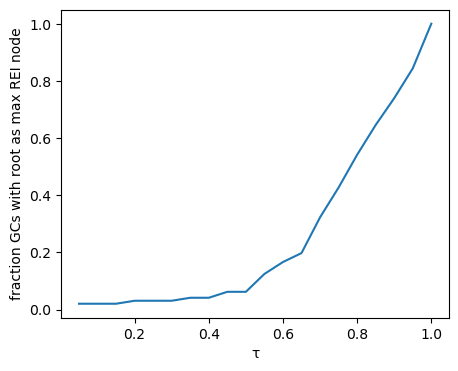

In [117]:
df.groupby("τ")[f"max {stat} node is root"].agg(lambda group: group.astype(int).sum() / len(group)).plot(xlabel="τ", ylabel=f"fraction GCs with root as max {stat} node", figsize=(5, 4));
# plt.xscale("log")

In [118]:
taus

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

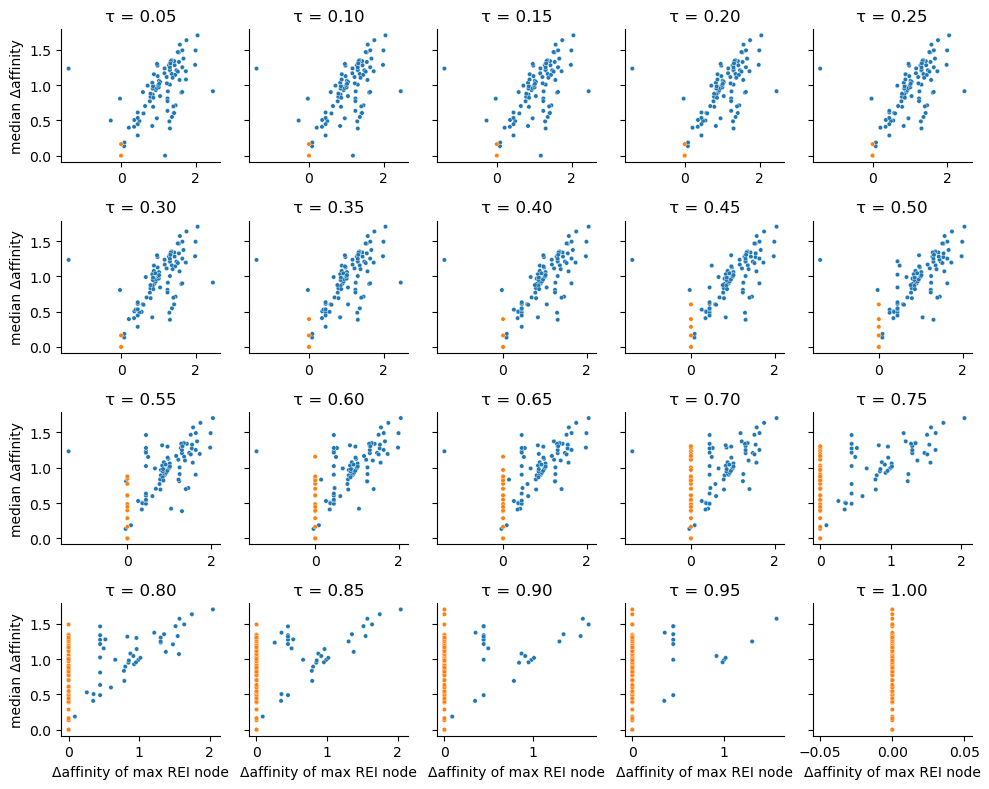

In [119]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x=f"Δaffinity of max {stat} node", y="median Δaffinity", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": False, "sharey": True})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()


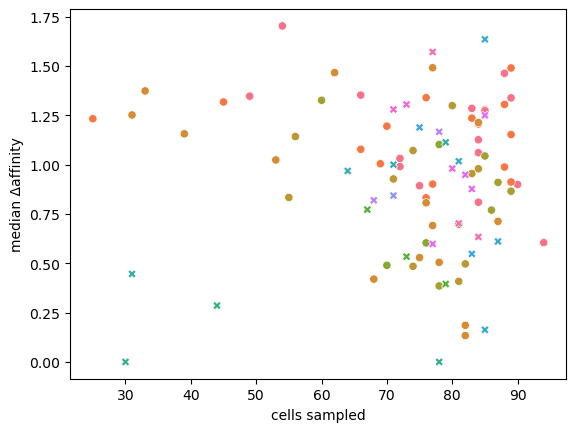

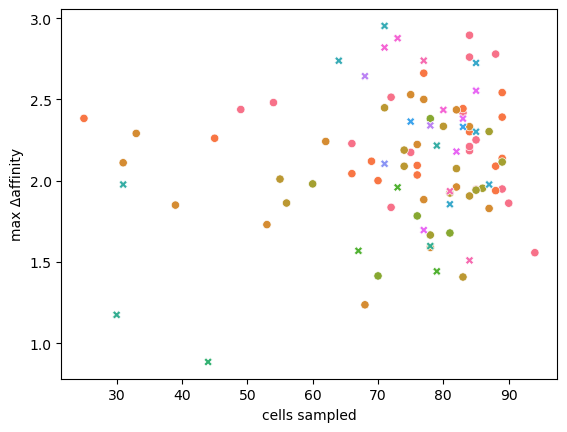

In [120]:
sns.scatterplot(data=df.loc[df.τ == taus[0]], x="cells sampled", y=f"median Δaffinity", hue="mouse", style="PR", legend=False)
plt.show()

sns.scatterplot(data=df.loc[df.τ == taus[0]], x="cells sampled", y=f"max Δaffinity", hue="mouse", style="PR", legend=False)
plt.show()

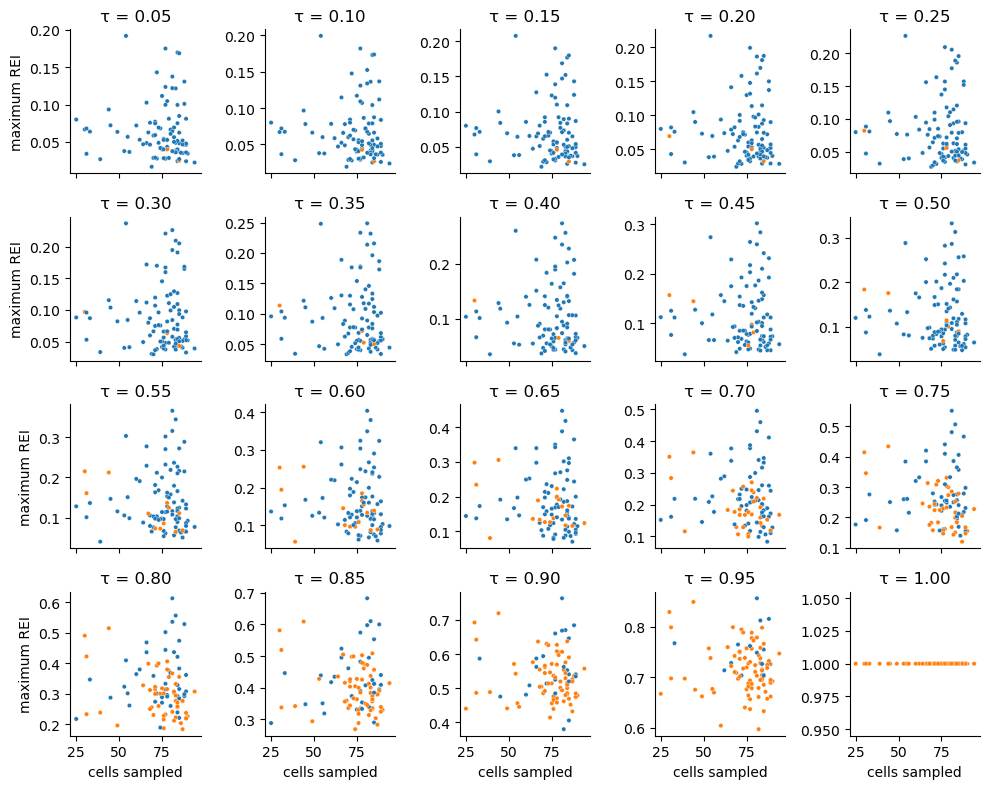

In [121]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x="cells sampled", y=f"maximum REI", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": True, "sharey": False})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()

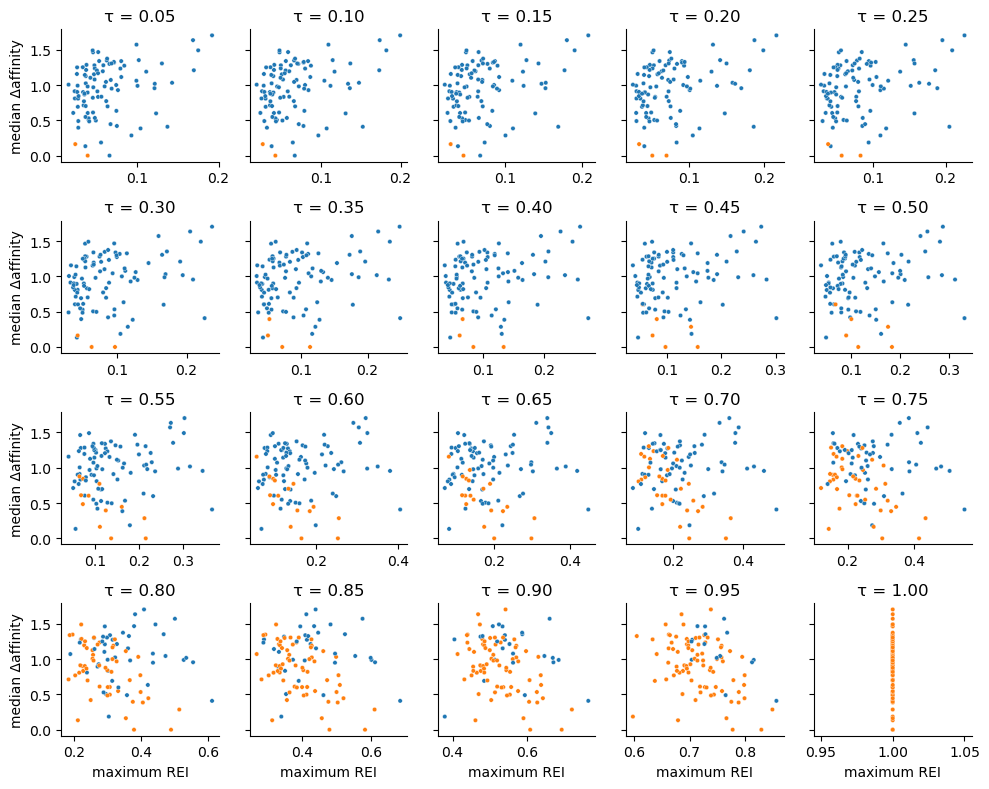

In [122]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x=f"maximum REI", y="median Δaffinity", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": False, "sharey": True})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()

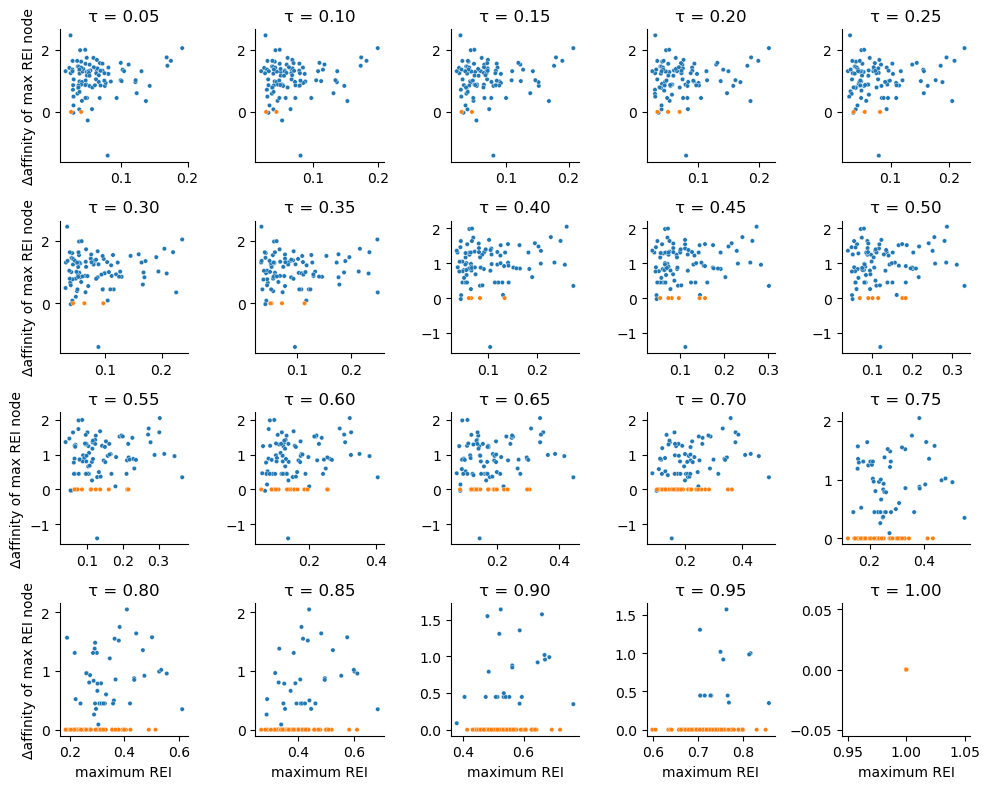

In [123]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x=f"maximum REI", y=f"Δaffinity of max {stat} node", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": False, "sharey": False})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


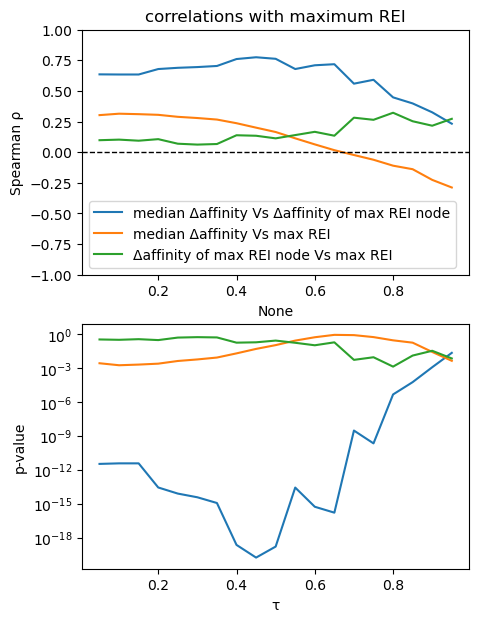

In [124]:
cor_df = pd.DataFrame()
for gc, group_df in df.groupby("τ"):
    ρ_node, p_node = sp.stats.spearmanr(group_df[f"Δaffinity of max {stat} node"], group_df[f"maximum {stat}"])
    ρ_gc, p_gc = sp.stats.spearmanr(group_df[f"median Δaffinity"], group_df[f"maximum {stat}"])
    ρ_aff, p_aff = sp.stats.spearmanr(group_df[f"median Δaffinity"], group_df[f"Δaffinity of max {stat} node"])
    cor_df.loc[gc, "ρ_node"] = ρ_node
    cor_df.loc[gc, "ρ_gc"] = ρ_gc
    cor_df.loc[gc, "p_node"] = p_node
    cor_df.loc[gc, "p_gc"] = p_gc
    cor_df.loc[gc, "ρ_aff"] = ρ_aff
    cor_df.loc[gc, "p_aff"] = p_aff

plt.figure(figsize=(5, 7))
plt.subplot(2, 1, 1)
plt.title(f"correlations with maximum {stat}")
sns.lineplot(data=cor_df, x=cor_df.index, y="ρ_aff", label=f"median Δaffinity Vs Δaffinity of max {stat} node")
sns.lineplot(data=cor_df, x=cor_df.index, y="ρ_gc", label=f"median Δaffinity Vs max {stat}")
sns.lineplot(data=cor_df, x=cor_df.index, y="ρ_node", label=f"Δaffinity of max {stat} node Vs max {stat}")
plt.axhline(0, color="k", ls="--", lw=1)
# plt.xlabel("τ")
plt.ylabel("Spearman ρ")
plt.ylim(-1, 1)
plt.legend()

plt.subplot(2, 1, 2)
sns.lineplot(data=cor_df, x=cor_df.index, y="p_aff")
sns.lineplot(data=cor_df, x=cor_df.index, y="p_gc")
sns.lineplot(data=cor_df, x=cor_df.index, y="p_node")
plt.xlabel("τ")
plt.ylabel("p-value")
plt.yscale("log")
plt.show()

In [125]:
# outcome = "mean Δaffinity"
# outcome = "median Δaffinity"
# outcome = "95th percentile Δaffinity"
outcome = f"Δaffinity of max {stat} node"
# outcome = f"ΔΔaffinity of max {stat} node"

In [126]:
# tau = taus[np.where(tau_cor_df.ρ > 0, tau_cor_df.p, 1).argmin()]
tau = taus[9]
tau

0.49999999999999994

Need to recompute tree stats using the chosen $\tau$

In [127]:
for tree in trees.values():
    calc_tree_stat(tree, stat, tau)

In [128]:
df = df.loc[df["τ"] == tau].sort_values(f"maximum {stat}").reset_index()
df

,index,τ,PR,mouse,germinal center,time,cells sampled,normalized dominance score,maximum REI,max Δaffinity,95th percentile Δaffinity,mean Δaffinity,median Δaffinity,Δaffinity of max REI node,ΔΔaffinity of max REI node,max REI node is root
0,907,0.5,PR1,PR1_3,PR1_mouse3_GC64,d20,39.0,0.435897,0.038462,1.850506,1.695969,1.001682,1.156395,1.357550,0.052247,False
1,903,0.5,PR1,PR1_3,PR1_mouse3_GC56,d20,87.0,0.413793,0.047593,1.829732,1.543696,0.779229,0.712662,1.457166,0.993175,False
2,951,0.5,PR2,PR2_10,PR2_mouse10_GC10B,d15,83.0,0.439024,0.048616,2.382069,1.624629,0.665275,0.876937,0.760290,-0.043584,False
3,901,0.5,PR1,PR1_3,PR1_mouse3_GC46,d20,82.0,0.390244,0.048780,1.961632,1.546807,0.106270,0.133744,0.083486,0.072970,False
4,905,0.5,PR1,PR1_3,PR1_mouse3_GC58,d20,76.0,0.684211,0.050164,2.223167,1.986581,0.530252,0.806844,-0.028390,-0.000292,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,909,0.5,PR1,PR1_3,PR1_mouse3_GC66,d20,77.0,0.727273,0.281859,2.500208,1.764862,0.850870,1.491315,1.637519,0.493843,False
92,942,0.5,PR2,PR2_6,PR2_mouse6_GC6B,d15,81.0,0.839506,0.285880,1.855661,1.557156,0.775080,1.017391,1.017391,1.017391,False
93,880,0.5,PR1,PR1_1,PR1_mouse1_GC7,d20,54.0,0.796296,0.287833,2.480766,2.265101,0.991590,1.703344,2.044751,0.803875,False
94,918,0.5,PR1,PR1_4,PR1_mouse4_GC70,d20,83.0,0.987952,0.312688,1.408283,1.077436,0.825024,0.955074,0.955074,-0.028470,False


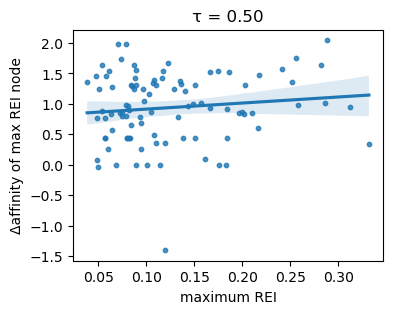

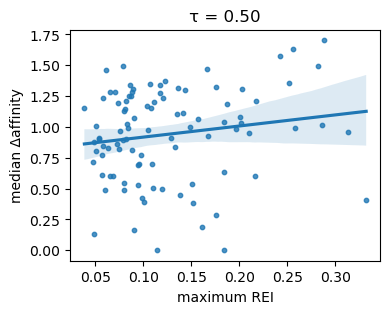

In [129]:
plt.figure(figsize=(4, 3))
sns.regplot(data=df, x=f"maximum {stat}", y=outcome, scatter_kws=dict(s=10))
plt.title(f"τ = {tau:.2f}")
plt.show()

# plt.figure(figsize=(4, 3))
# sns.regplot(data=df.loc[df[outcome] != 0], x=f"maximum {stat}", y=outcome, scatter_kws=dict(s=10), label="no roots")
# plt.title(f"τ = {tau:.2f}")
# plt.legend()
# plt.show()

plt.figure(figsize=(4, 3))
sns.regplot(data=df, x=f"maximum {stat}", y="median Δaffinity", scatter_kws=dict(s=10))
plt.title(f"τ = {tau:.2f}")
plt.show()

In [130]:
thresh = 0.15

In [131]:
output_dir = "output/NDS-LB"

In [132]:
df.to_csv(f"{output_dir}/data.csv")

## Rank plot of total GC cell abundance 

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

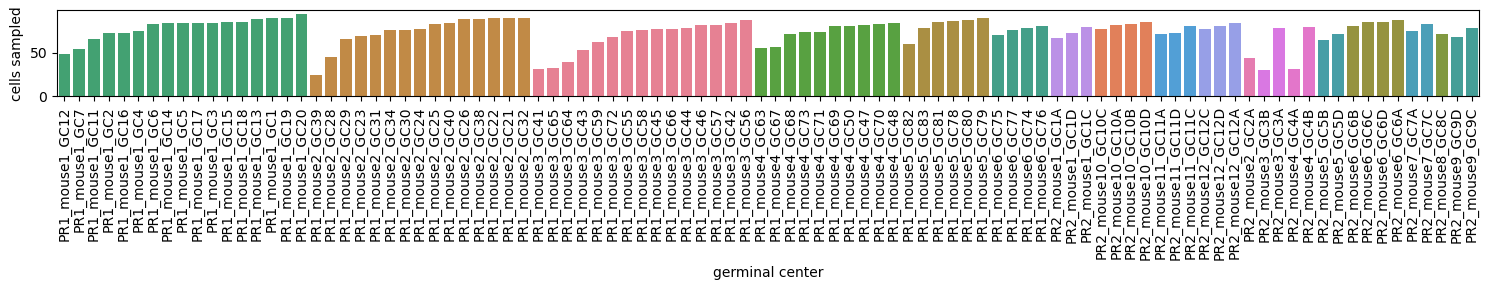

In [133]:
plt.figure(figsize=(15, 3))
ax = sns.barplot(data=df.sort_values(["mouse", "cells sampled"]), x="germinal center", y="cells sampled", hue="mouse",
                 hue_order=df.mouse.unique(),
                 legend=False,
                 dodge=False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"{output_dir}/abundances.pdf")
plt.show()

## Plot tree shape stats in a scatter plot, and render some example trees
For each tree we render it colored by fitness statistic, then by affinity, and by fitness stat

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/relational.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/relational.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


PR2_mouse1_GC1D REI


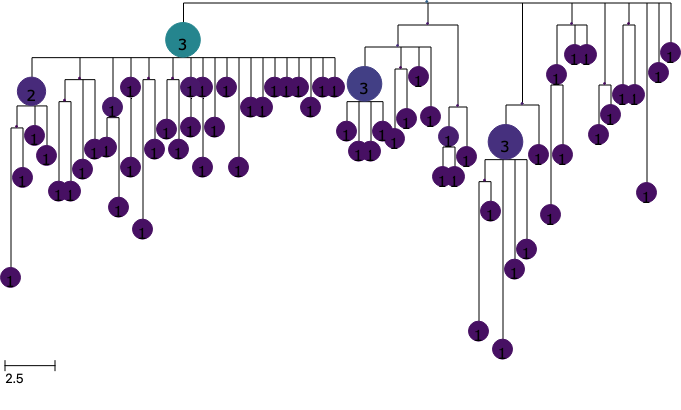

PR2_mouse1_GC1D Δaffinity


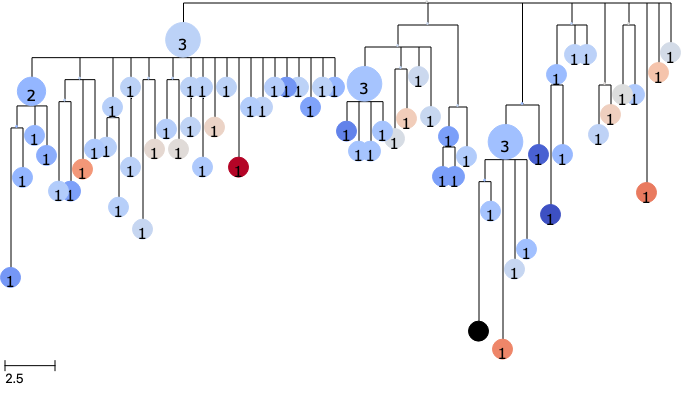

PR1_mouse5_GC83 REI


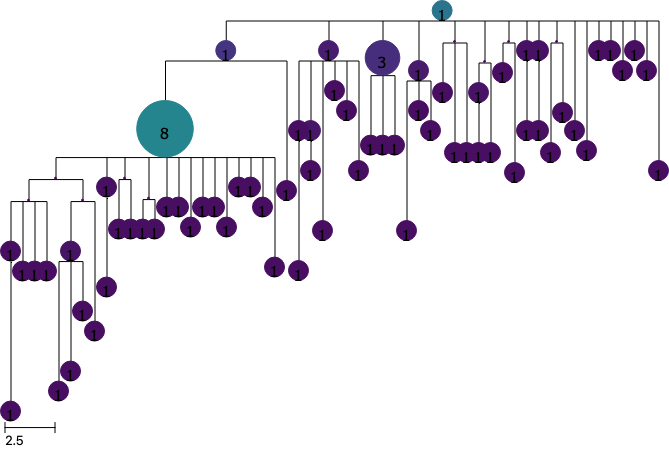

PR1_mouse5_GC83 Δaffinity


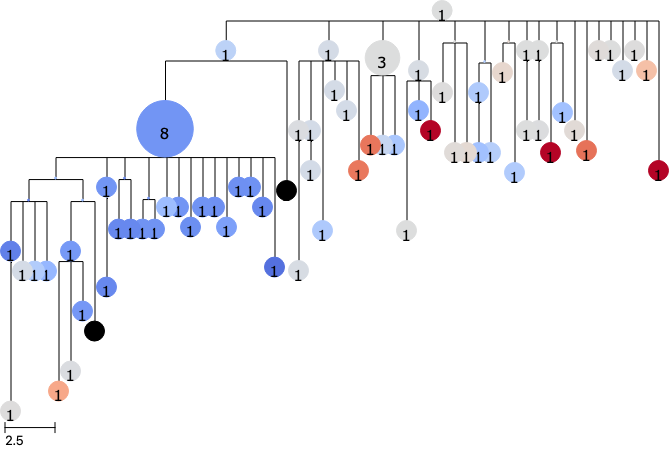

PR1_mouse1_GC17 REI


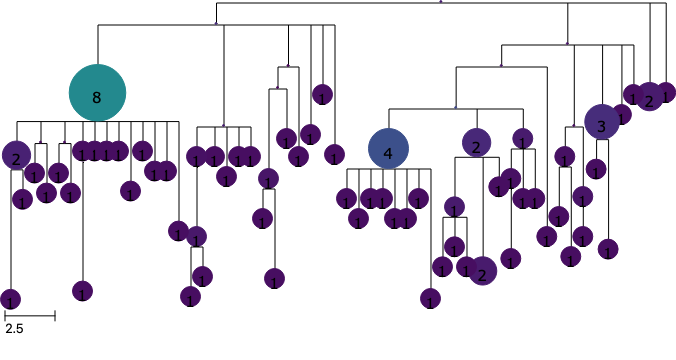

PR1_mouse1_GC17 Δaffinity


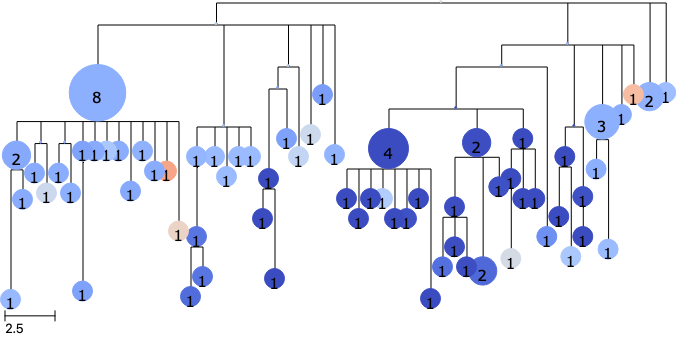

PR1_mouse3_GC57 REI


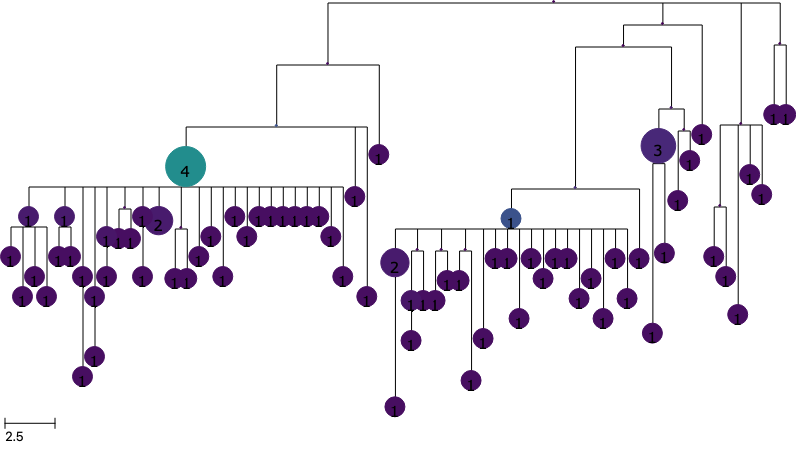

PR1_mouse3_GC57 Δaffinity


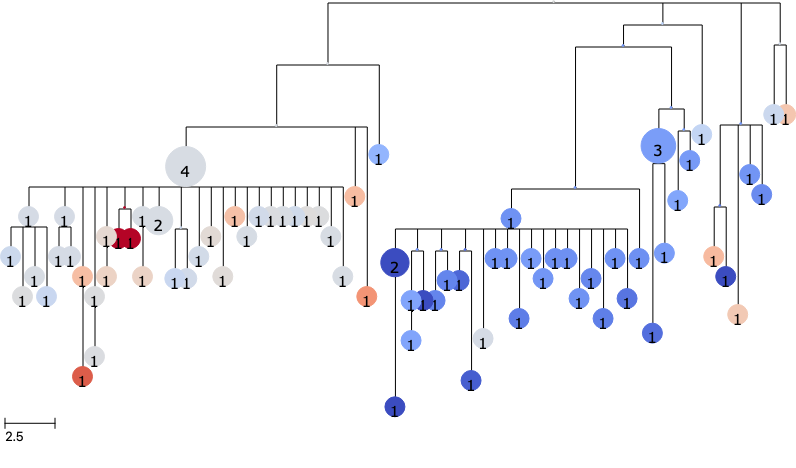

PR1_mouse3_GC59 REI


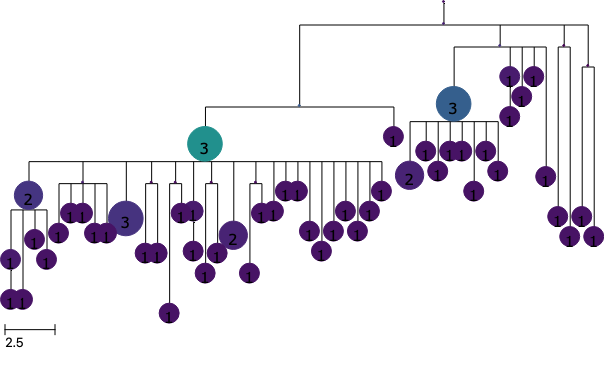

PR1_mouse3_GC59 Δaffinity


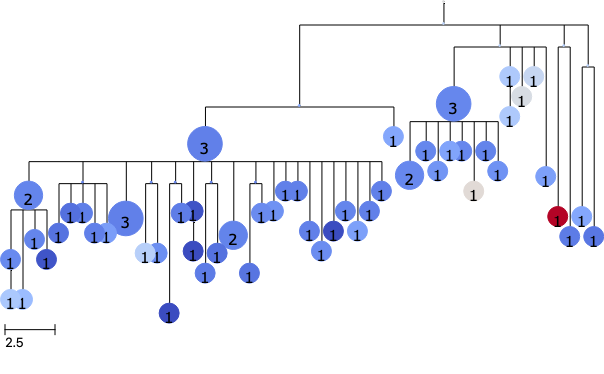

PR1_mouse4_GC68 REI


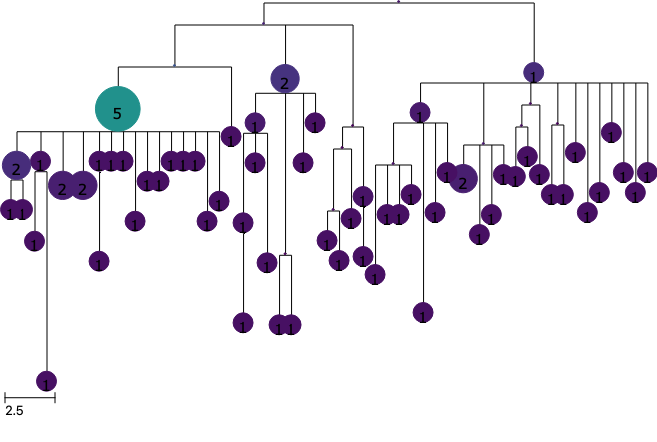

PR1_mouse4_GC68 Δaffinity


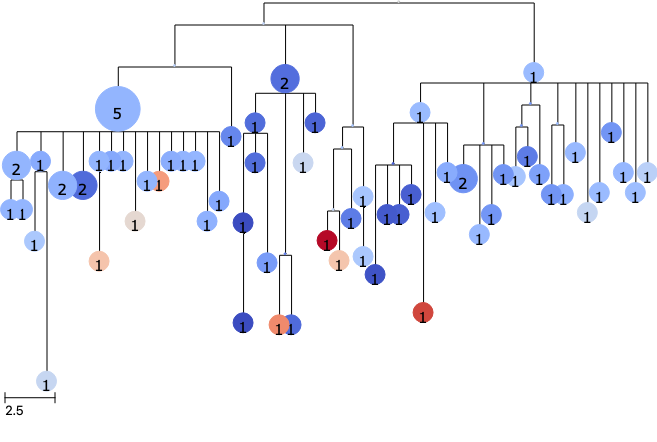

PR1_mouse5_GC82 REI


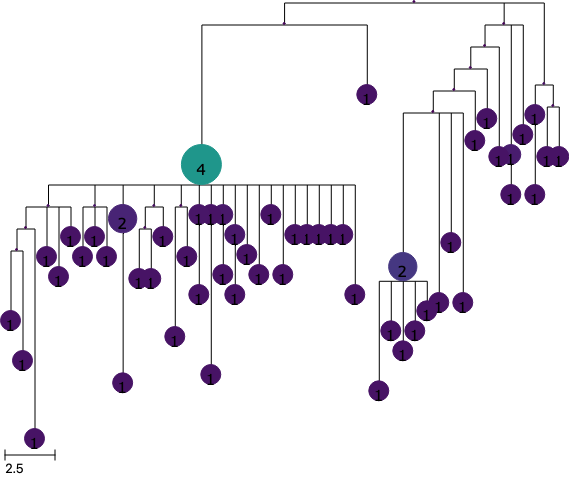

PR1_mouse5_GC82 Δaffinity


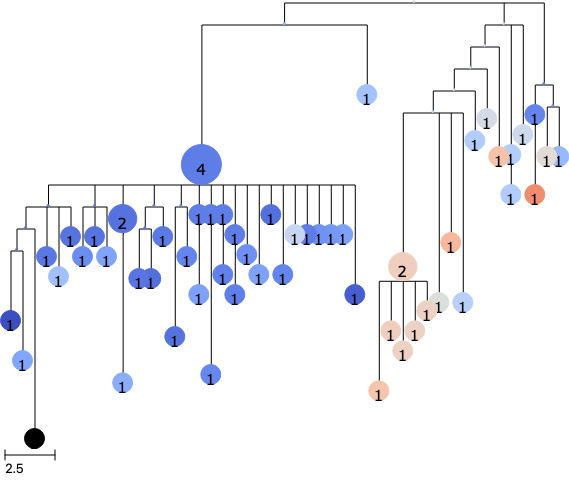

PR2_mouse2_GC2A REI
NOTE: max REI node is root


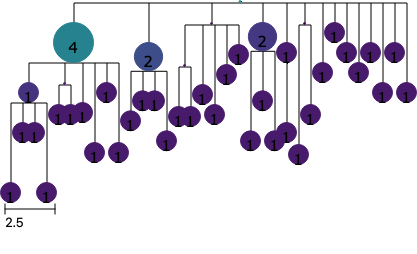

PR2_mouse2_GC2A Δaffinity


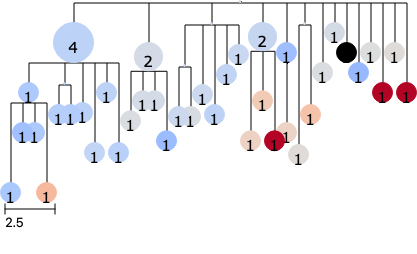

PR2_mouse3_GC3B REI
NOTE: max REI node is root


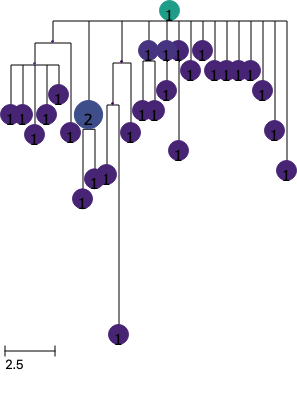

PR2_mouse3_GC3B Δaffinity


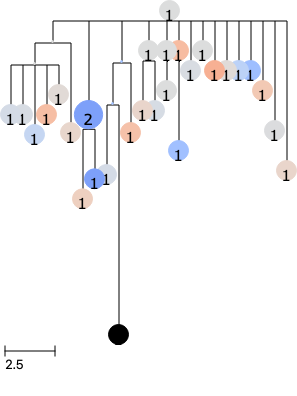

PR1_mouse5_GC81 REI


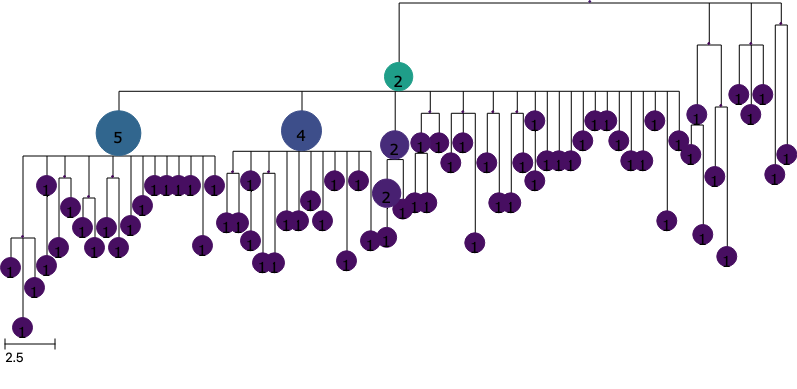

PR1_mouse5_GC81 Δaffinity


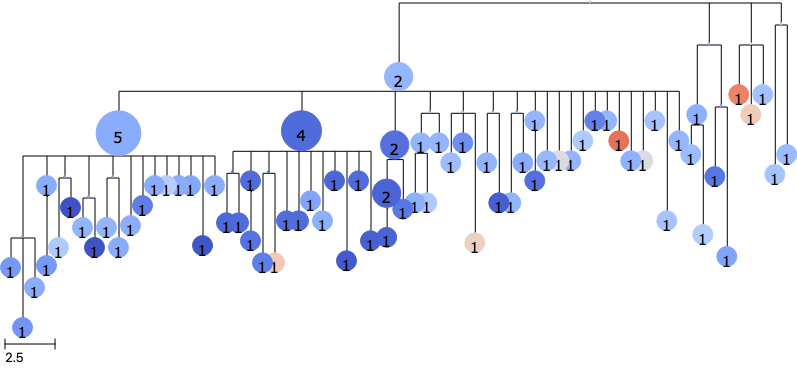

PR2_mouse12_GC12A REI


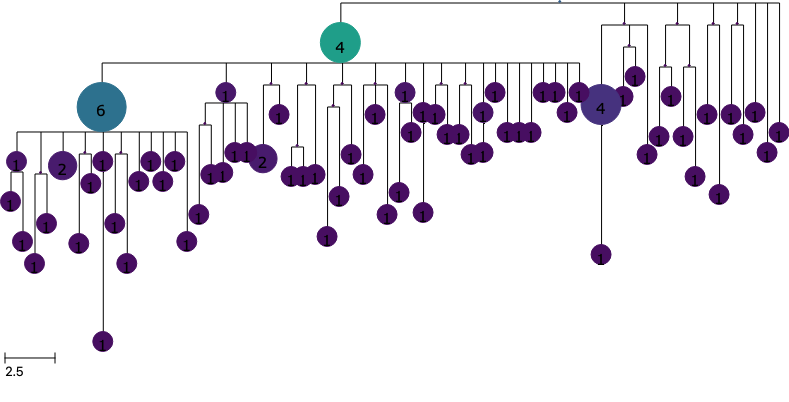

PR2_mouse12_GC12A Δaffinity


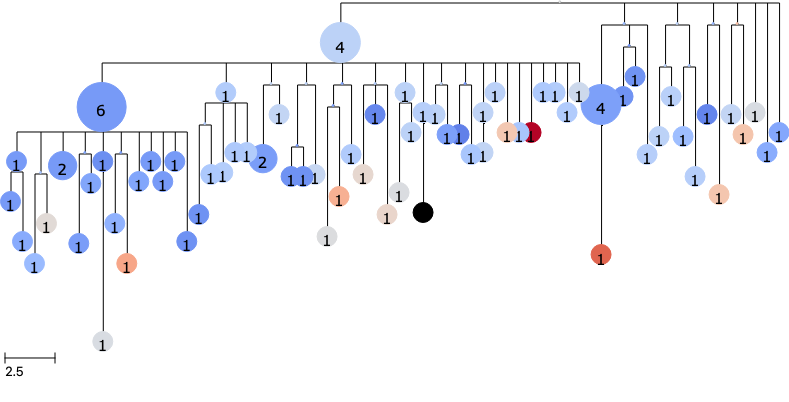

PR2_mouse7_GC7A REI


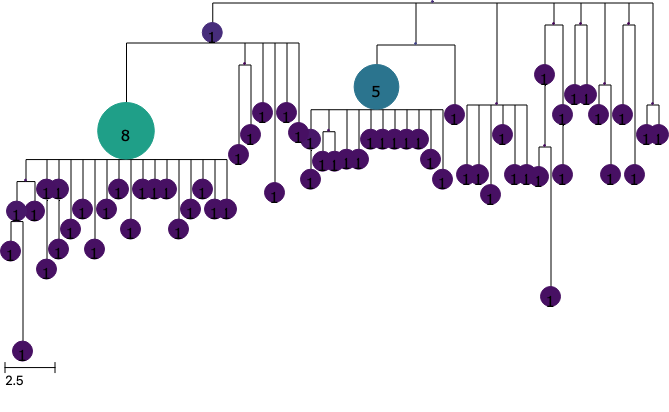

PR2_mouse7_GC7A Δaffinity


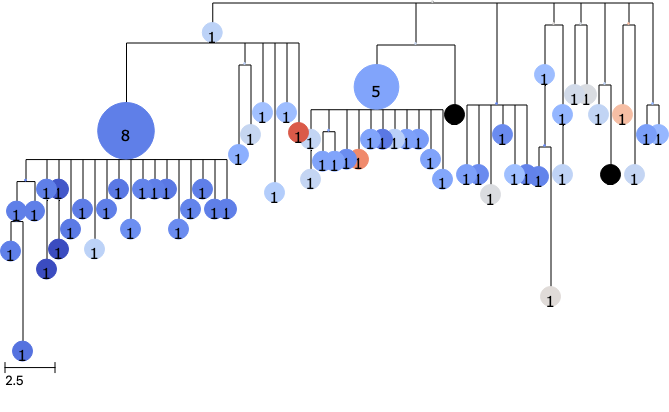

PR2_mouse11_GC11C REI


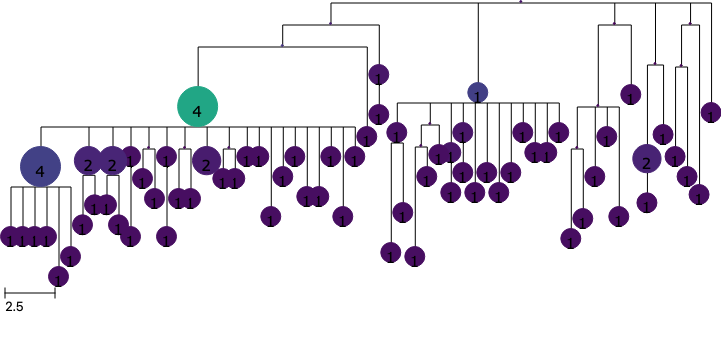

PR2_mouse11_GC11C Δaffinity


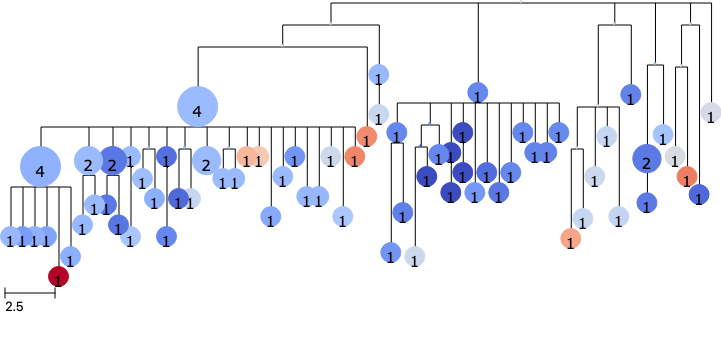

PR1_mouse2_GC29 REI


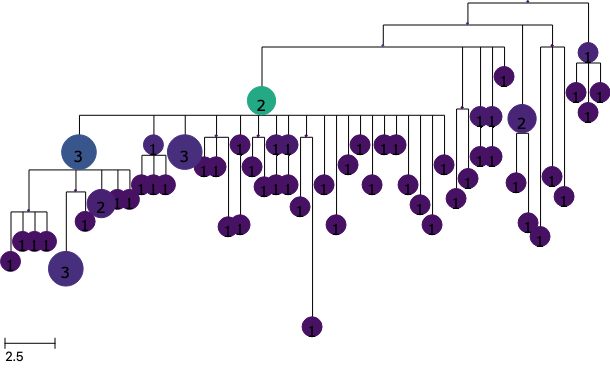

PR1_mouse2_GC29 Δaffinity


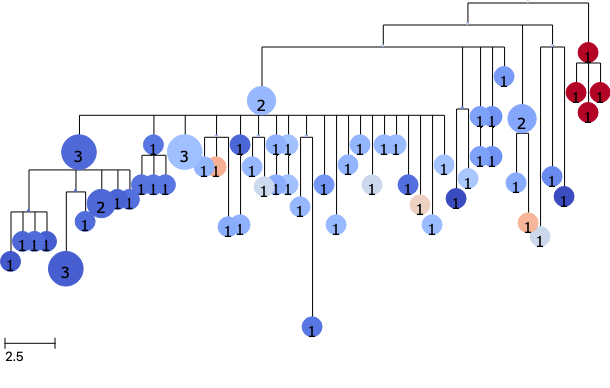

PR1_mouse1_GC16 REI


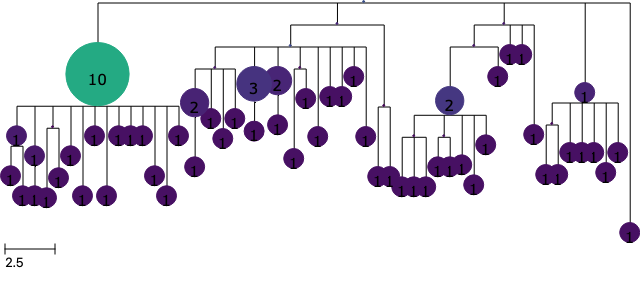

PR1_mouse1_GC16 Δaffinity


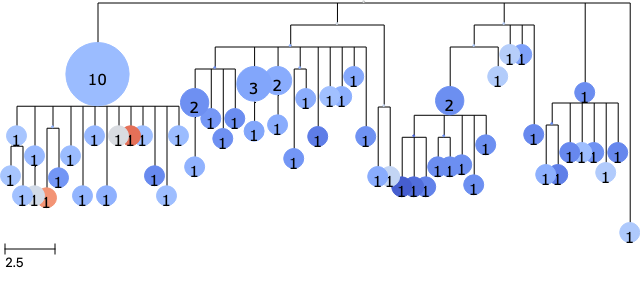

PR1_mouse2_GC26 REI


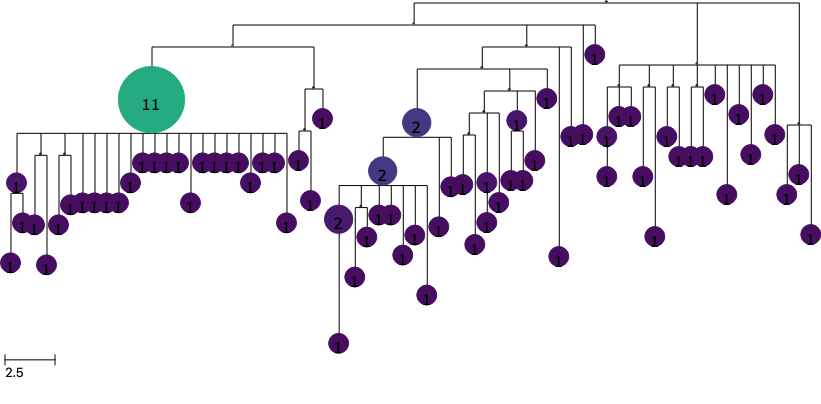

PR1_mouse2_GC26 Δaffinity


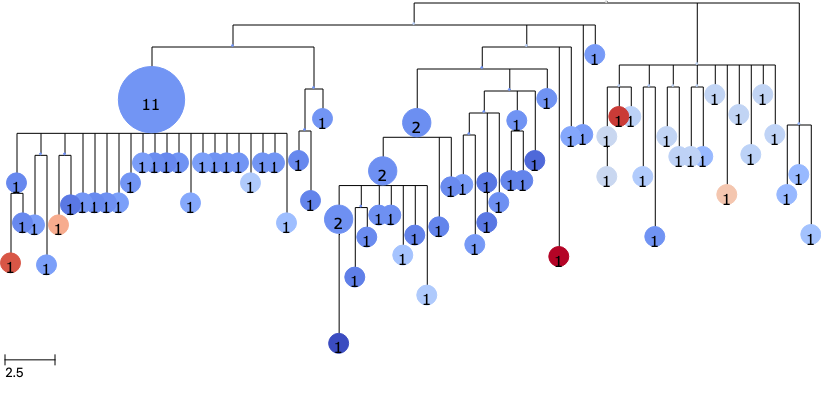

PR2_mouse10_GC10A REI


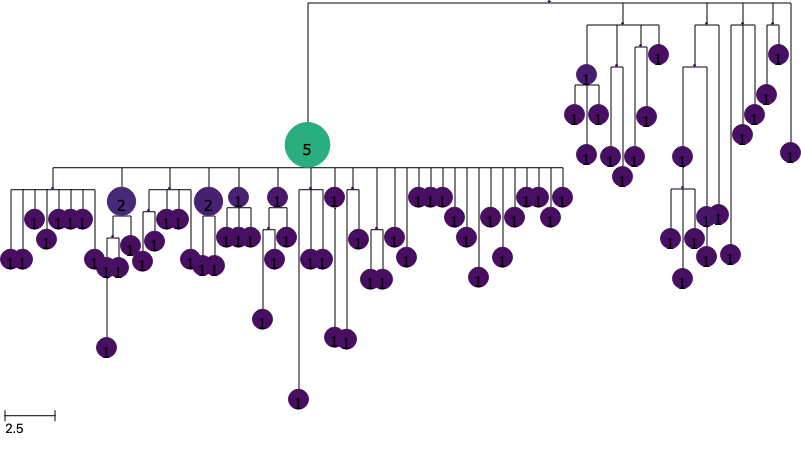

PR2_mouse10_GC10A Δaffinity


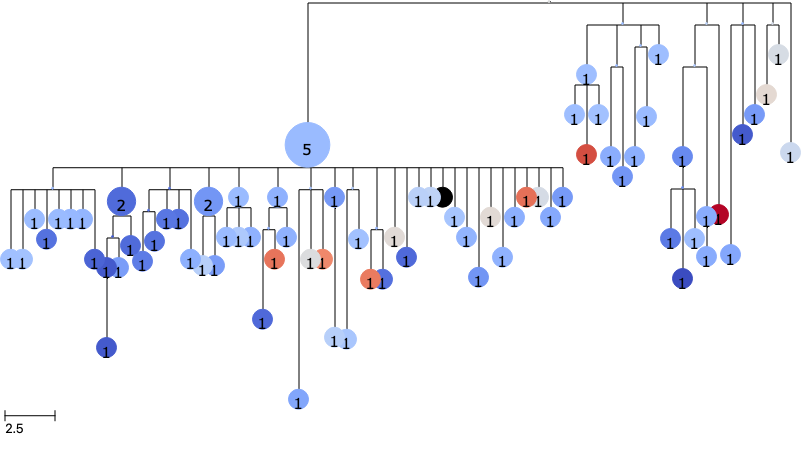

PR2_mouse10_GC10C REI


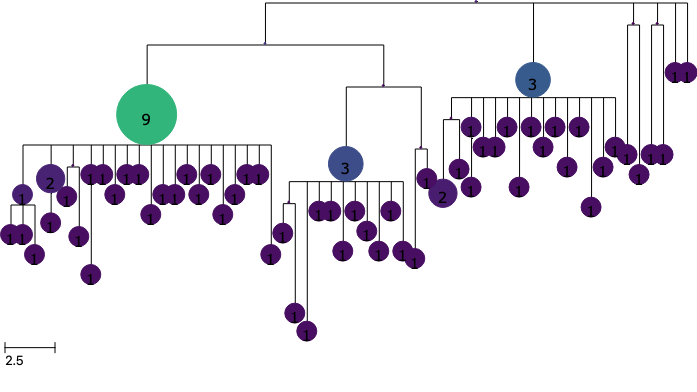

PR2_mouse10_GC10C Δaffinity


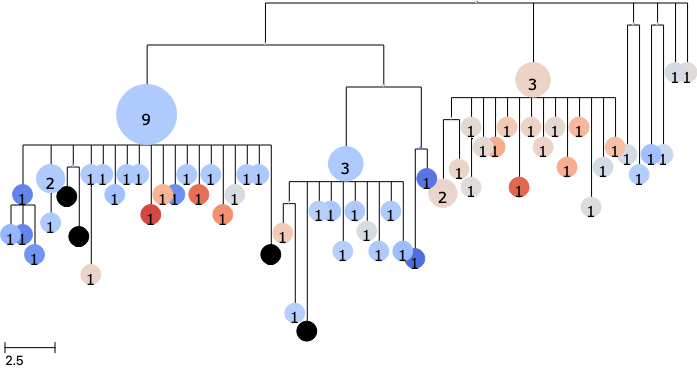

PR1_mouse1_GC3 REI


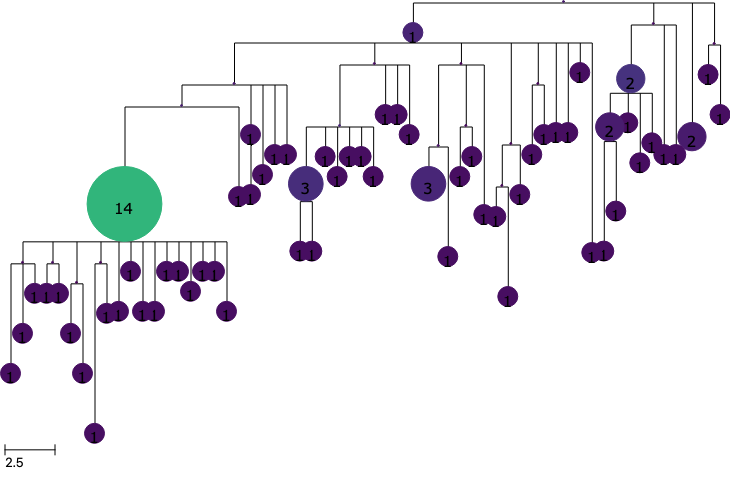

PR1_mouse1_GC3 Δaffinity


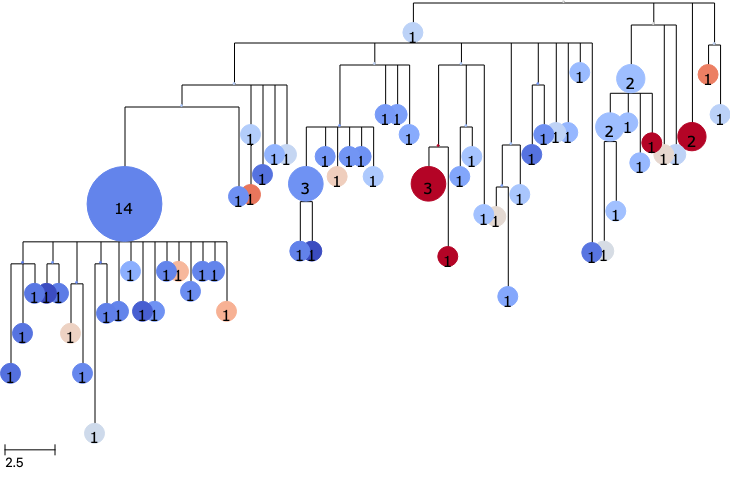

PR2_mouse12_GC12C REI


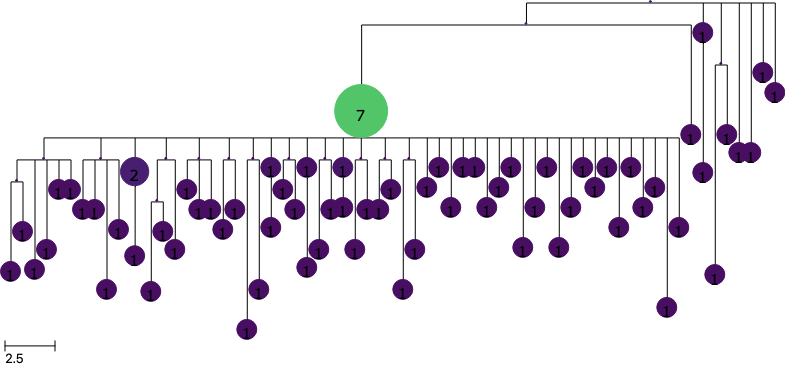

PR2_mouse12_GC12C Δaffinity


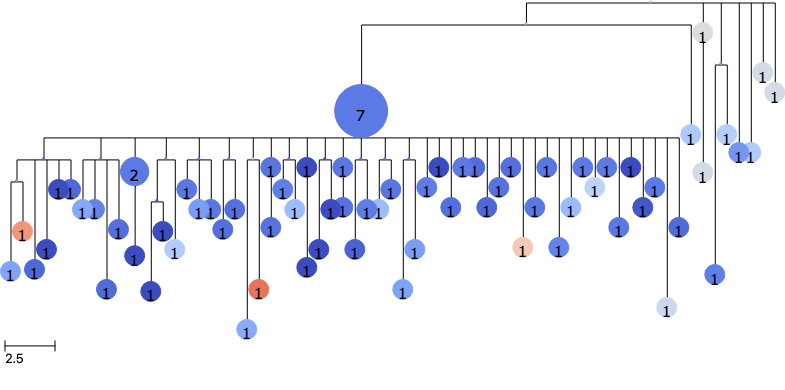

PR1_mouse1_GC11 REI


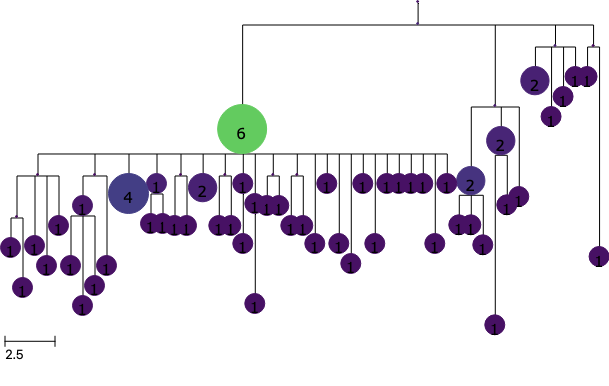

PR1_mouse1_GC11 Δaffinity


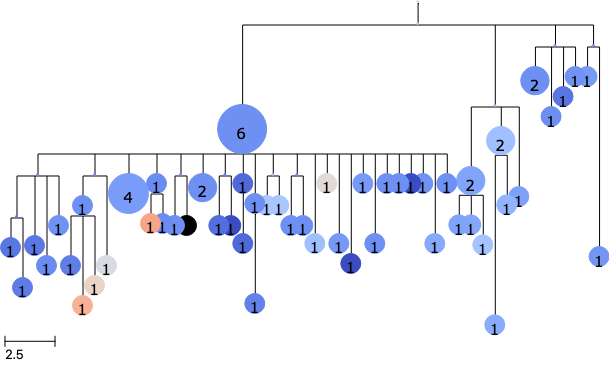

PR2_mouse6_GC6D REI


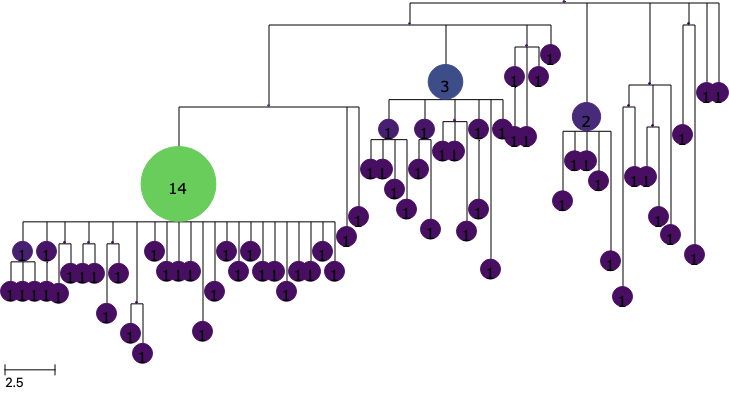

PR2_mouse6_GC6D Δaffinity


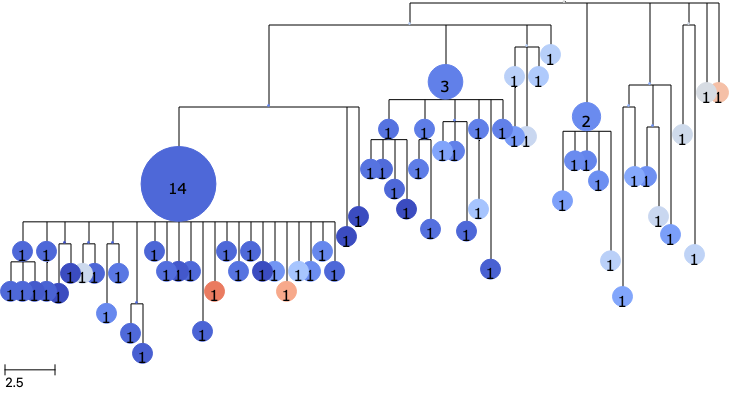

PR1_mouse2_GC38 REI


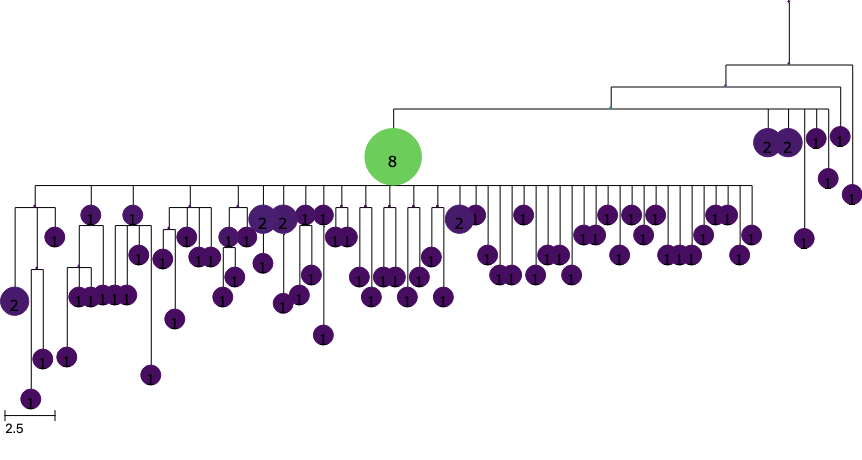

PR1_mouse2_GC38 Δaffinity


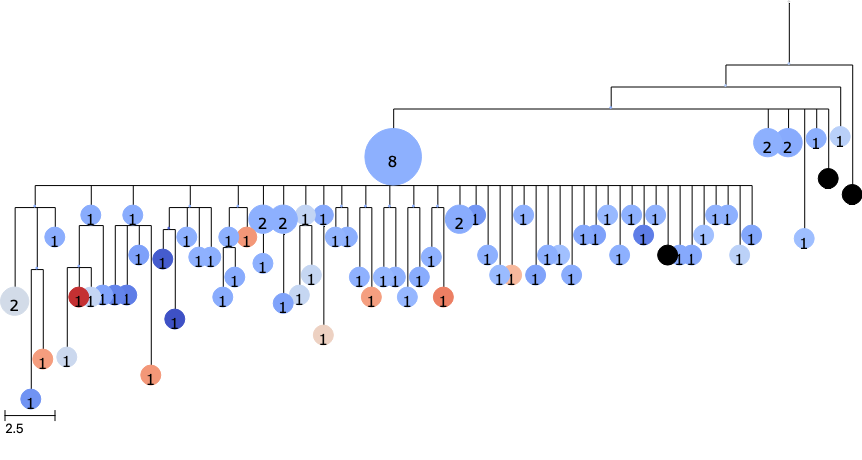

PR1_mouse3_GC66 REI


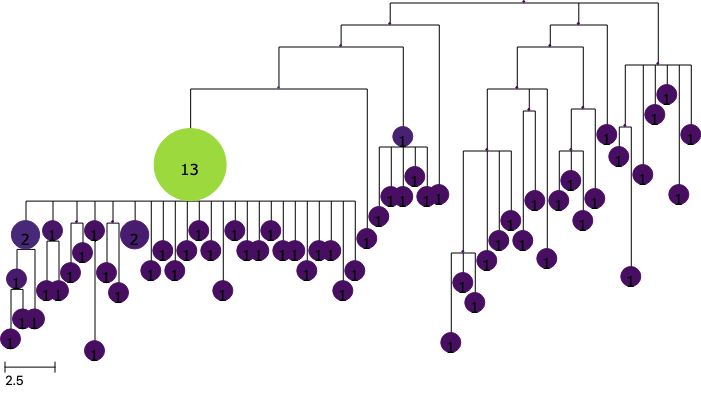

PR1_mouse3_GC66 Δaffinity


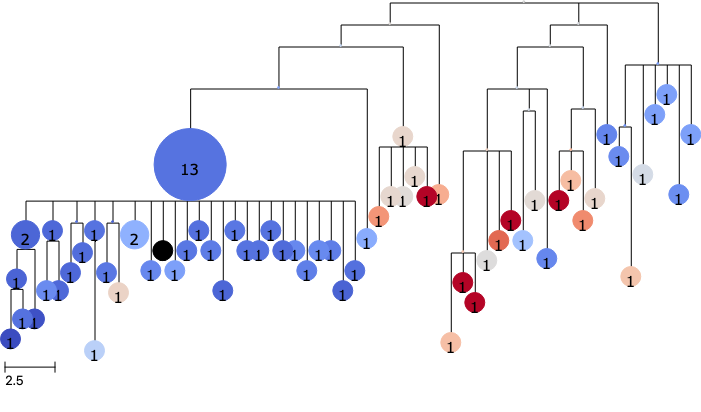

PR2_mouse6_GC6B REI


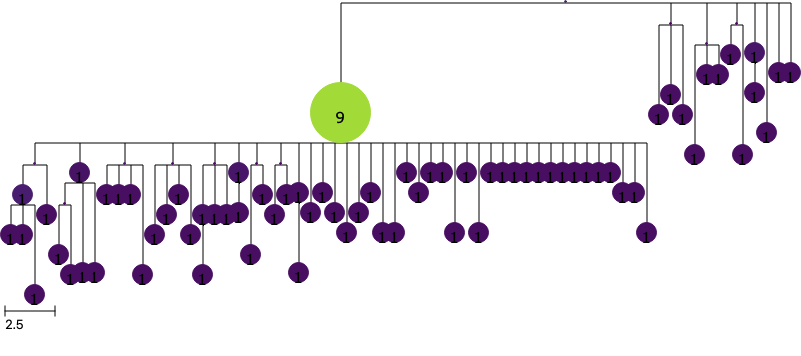

PR2_mouse6_GC6B Δaffinity


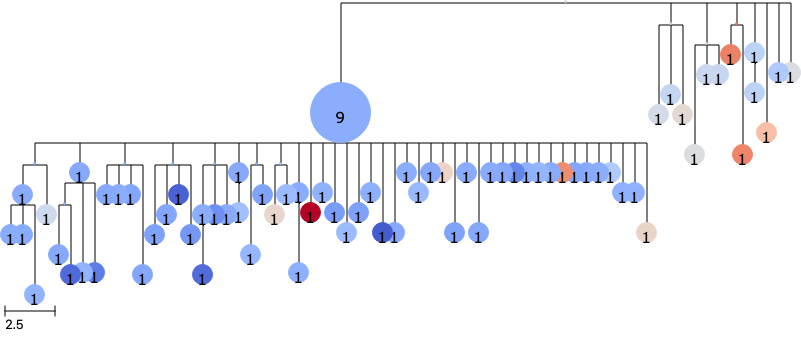

PR1_mouse1_GC7 REI


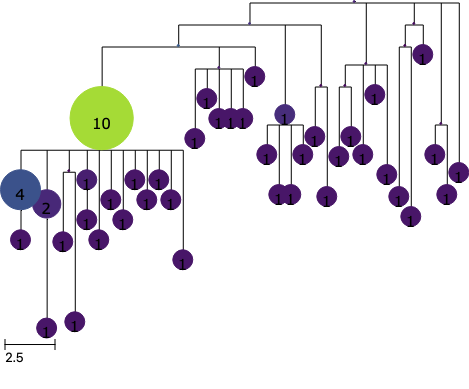

PR1_mouse1_GC7 Δaffinity


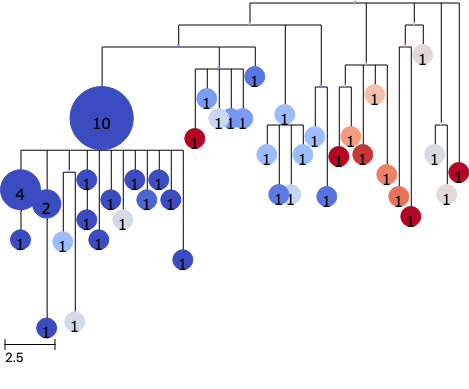

PR1_mouse4_GC70 REI


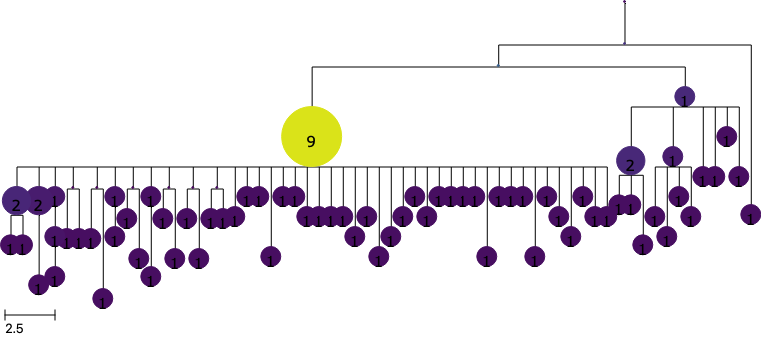

PR1_mouse4_GC70 Δaffinity


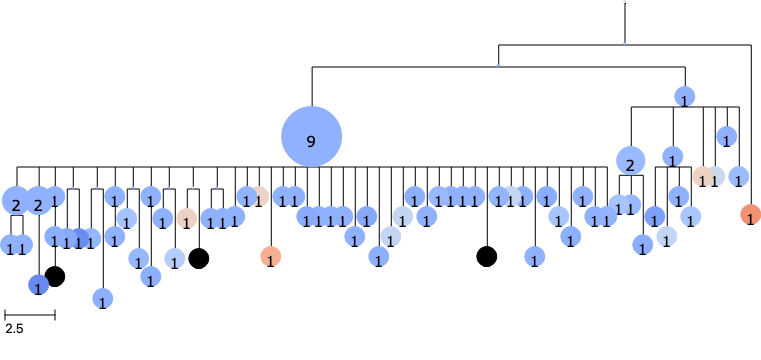

PR1_mouse4_GC50 REI


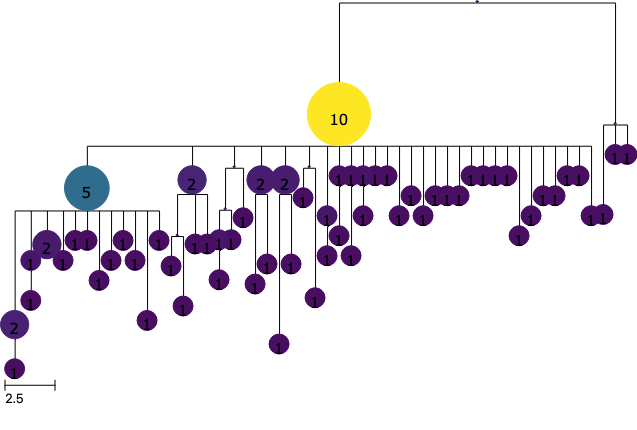

PR1_mouse4_GC50 Δaffinity


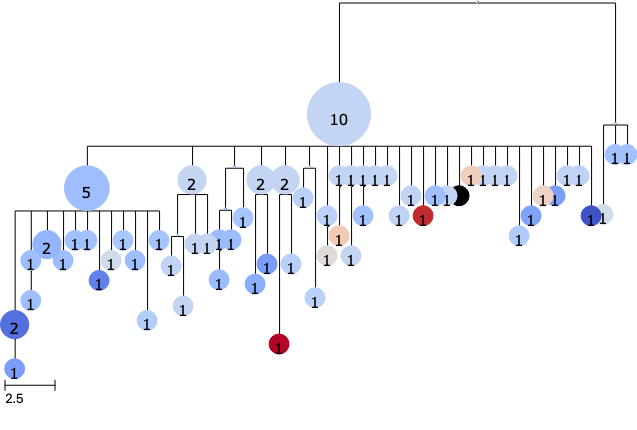

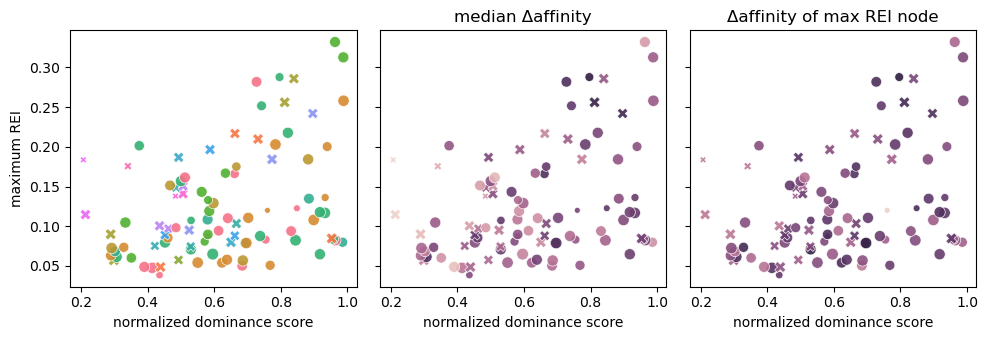

In [134]:
# stat cmap
cmap = "viridis"
vmin = min(getattr(node, stat) for tree in trees.values() for node in tree.tree.traverse())
vmax = max(getattr(node, stat) for tree in trees.values() for node in tree.tree.traverse())

# affinity cmap
cmap2 = "coolwarm_r"
vmin2 = -2
vmax2 = 2

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True)
sns.scatterplot(data=df, x="normalized dominance score", y=f"maximum {stat}", hue="mouse", size="cells sampled", style="time",
                clip_on=False, alpha=0.9,
                legend=False,
                ax=ax1)
# sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax2.set_title("median Δaffinity")
sns.scatterplot(data=df, x="normalized dominance score", y=f"maximum {stat}", hue="median Δaffinity", size="cells sampled", style="time",
                clip_on=False, alpha=0.9,
                cmap=cmap2,
                legend=False,
                ax=ax2)
ax3.set_title(outcome)
sns.scatterplot(data=df, x="normalized dominance score", y=f"maximum {stat}", hue=outcome, size="cells sampled", style="time",
                clip_on=False, alpha=0.9,
                cmap=cmap2,
                legend=False,
                ax=ax3)
# ax1.set_yscale("log")
# ax2.set_yscale("log")
# ax3.set_yscale("log")
for i, row in df.iterrows():
    x, y = row[["normalized dominance score", f"maximum {stat}"]]
    key = df["germinal center"][i]
    colormap1 = trees[key].feature_colormap(stat, vmin=vmin, vmax=vmax, scale="symlog", linthresh=1, cmap=cmap)
    for scale in (5, 20):
        trees[key].render(f"{output_dir}/trees/{key}.{stat}.scale{scale}.svg", colormap=colormap1, scale=scale, branch_margin=-8)
    if row[f"maximum {stat}"] > thresh:
        print(row["germinal center"], stat)
        if row[f"max {stat} node is root"]:
            print(f"NOTE: max {stat} node is root")
        display(trees[key].render("%%inline", colormap=colormap1, scale=20, branch_margin=-8))
    colormap2 = trees[key].feature_colormap("delta_bind", vmin=vmin2, vmax=vmax2, cmap=cmap2)
    for scale in (5, 20):
        trees[key].render(f"{output_dir}/trees/{key}.binding.scale{scale}.svg", colormap=colormap2, scale=scale, branch_margin=-8)
    if row[f"maximum {stat}"] > thresh:
        print(row["germinal center"], "Δaffinity")
        display(trees[key].render("%%inline", colormap=colormap2, scale=20, branch_margin=-8))
plt.tight_layout()
plt.savefig(f"{output_dir}/scatter.pdf")
plt.show()

## Color bars for the tree colormaps

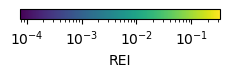

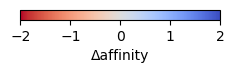

In [135]:
fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax)),
             orientation='horizontal',
             cax=cax,
             label=f"{stat}")
plt.savefig(f"{output_dir}/cbar1.pdf", bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap2, norm=Normalize(vmin=vmin2, vmax=vmax2)),
             orientation='horizontal',
             cax=cax,
             label="Δaffinity")
plt.savefig(f"{output_dir}/cbar2.pdf", bbox_inches="tight")
plt.show()

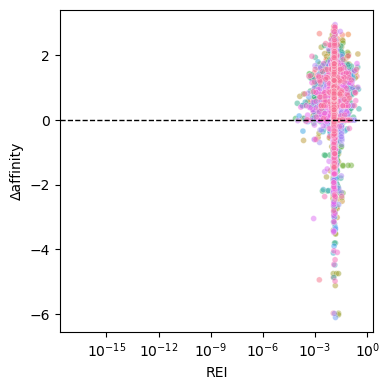

In [138]:
dat = []
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        dat.append([gc, getattr(node, stat), node.delta_bind])

df_nodes = pd.DataFrame(dat, columns=["germinal center", stat, "Δaffinity"])

plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_nodes, x=stat, y="Δaffinity", hue="germinal center", legend=False, alpha=0.5, size=.1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.axvline(0, ls="--", c="k", lw=1)
plt.xscale("log")
plt.tight_layout()
plt.show()

## Summary

- Developed REI, because no branch lengths with LB
- Doesn't correlate will with GC affinity
- Recent motivated by evolving affinity

